# Vehicle Model

We consider the double integrator as a model for UAV flight path simulation model as below.

The system dynamics 

\begin{equation}
x_{t+1} = A x_t + B u_t, \quad x_0 = [0 ,0, 0, 0]^\top,
\end{equation}
where
\begin{equation}
A = \begin{bmatrix}
     1 & 0 & 0.1 & 0   \\
     0 & 1 &  0 & 0.1 \\
     0 & 0 &  1+a & 0   \\
     0 & 0 &  0 & 1+a
     \end{bmatrix}
\quad
B = \begin{bmatrix}
     0  & 0  \\
     0  & 0  \\
     0.1 & 0  \\
     0  & 0.1
     \end{bmatrix}
\end{equation} 

Now, we need to feed the control input tensor to the dynamics for the time horizon $N$.

We consider the primary desination (8, 8).

And the usual quadratic cost are used with
\begin{equation}
L_\text{q}(x, u) = (x - x_\text{tgt})^\top Q (x - x_\text{tgt}) + u^\top R u
\end{equation}

Now, we are considering the obstacle avoidance constraint. A simple inequality with vertices (4, 4) and (6, 8). The obstacle occupy the following intervals.
\begin{equation}
\begin{aligned}
    4 \leq x \leq 6 \\
    4 \leq y \leq 8
\end{aligned}
\end{equation}

We add the penalty cost to the quadratic cost with the penalty weight $W_\text{penalty}$ as
\begin{equation}
L(x, u) = L_\text{q}(x, u) + W_\text{penalty}\mathbb{1}[x \in \text{Obstacle}]
\end{equation}

In [73]:
import torch
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class TrajectoryOptimization:

    def __init__(self, a, N):
        
        ### Vehicle Dyanmics ###
        self.a = a
        self.A = torch.FloatTensor([[1, 0, 0.1, 0],[0, 1, 0, 0.1],[0, 0, 1+a,0],[0,0,0,1+a]]).to(DEVICE)
        self.B = torch.FloatTensor([[0, 0],[0, 0],[.1, 0],[0,.1]]).to(DEVICE)
        self.x_0 = torch.FloatTensor([0, 0, 0, 0]).to(DEVICE)
        
        ### PI Param ###
        self.N   = N  # Time horizon
        self.N_u = 2  # dimension of the control input.
        self.N_x = 4  # dimension of the state space.
        self.N_smpl = 1000000 # MPPI
        
        ### Cost for the mission ###
        self.X_goal = torch.FloatTensor([[10, 10, 0, 0]]).to(DEVICE)
        
        self.Q_running = torch.FloatTensor([[1, 0, 0, 0],[0, 1, 0, 0],[0, 0, 1, 0],[0, 0, 0, 1]]).to(DEVICE)
        self.R_running = torch.FloatTensor([[0, 0],[0, 0]]).to(DEVICE)

        self.Q_terminal = torch.FloatTensor([[1, 0, 0, 0],[0, 1, 0, 0],[0, 0, 1, 0],[0, 0, 0, 1]]).to(DEVICE)
        self.R_terminal = torch.FloatTensor([[0, 0],[0, 0]]).to(DEVICE)
        
        self.Box_to_Avoid = {}
        self.Box_to_Avoid.update({'LB_X':4})
        self.Box_to_Avoid.update({'UB_X':6})
        self.Box_to_Avoid.update({'LB_Y':4})
        self.Box_to_Avoid.update({'UB_Y':8})
        self.GAP = 0.2
        self.W_penalty = 10000
        
        
        
    def calculate_state_trajectories(self,x_0):
        '''
        given:
        A : 4 by 4 matrix
        B : 4 by 2 matrix
        x_0 initial state with size (4)
        U_tensor: N_path, M_destination, N_time, N_u, N_smpl

        return:
        XX_tensor: N_path, M_destination, N_time, N_u, N_smpl
        '''

        ### Get the shape of the input tensor ###
        U_tensor = torch.randn(self.N, self.N_u, self.N_smpl).to(DEVICE)
        N_time, N_u, N_smpl = U_tensor.size()

        ### Initialize the state value ###
        #print('x_0', x_0.size())
        X_t = x_0.unsqueeze(-1).repeat(1, 1, N_smpl)
        # X_t: 1, N_x, N_smpl

        X_t = X_t.to(DEVICE).permute(2,1,0)#.unsqueeze(-1)
        BB = self.B.unsqueeze(0).repeat(N_smpl, 1, 1).to(DEVICE)
        AA = self.A.unsqueeze(0).repeat(N_smpl, 1, 1).to(DEVICE)

        XX_tensor = []
        for t in range(N_time):
            U_t = U_tensor[t,:,:].permute(1,0).unsqueeze(-1)
            BU = torch.matmul(BB, U_t)
            AX = torch.matmul(AA, X_t)
            X_t = AX + BU
            XX_tensor.append(X_t)
        XX_tensor  = torch.stack(XX_tensor, -1).squeeze()
        return XX_tensor, U_tensor
    
    def calcualte_costs(self, XX, UU):
        
        N_smpl, N_state, N_time = XX.size()
        
        ### Repeat and reshaping the tensors ###
        XX_goal = self.X_goal.unsqueeze(-1)
        XX_goal = XX_goal.repeat(N_smpl, 1, N_time)
        
        ##################################
        ### Calculate the running cost ###
        ##################################
        
        ### Error Cost: x_T*Q*x ###
        QQ = self.Q_running.unsqueeze(0).unsqueeze(0).repeat(N_smpl, N_time, 1, 1)
        EE = (XX - XX_goal).unsqueeze(-1).permute(0,2,1,3)
        EE_T = EE.permute(0,1,3,2)
        EEQQEE = torch.matmul(EE_T, torch.matmul(QQ, EE))
        ### Control Cost: u_T*R*u ###
        RR = self.R_running.unsqueeze(0).unsqueeze(0).repeat(N_smpl, N_time, 1, 1)
        UU = UU.permute(2, 0, 1).unsqueeze(-1)
        UU_T = UU.permute(0,1,3,2)
        UURRUU = torch.matmul(UU_T, torch.matmul(RR, UU))
        ### Indicator in the obstacle space ###
        XX_x = XX[:, 0, :]
        XX_y = XX[:, 1, :]
        
        LB_X = self.Box_to_Avoid['LB_X']
        UB_X = self.Box_to_Avoid['UB_X']
        LB_Y = self.Box_to_Avoid['LB_Y']
        UB_Y = self.Box_to_Avoid['UB_Y']
        GAP  = self.GAP
        W_penalty = self.W_penalty
        
        If_Within_Obstacle = (XX_x > LB_X-GAP).type(torch.float)*(XX_x < UB_X+GAP).type(torch.float)*(XX_y > LB_Y-GAP).type(torch.float)*(XX_y < UB_Y+GAP).type(torch.float)
        If_Within_Obstacle = If_Within_Obstacle.unsqueeze(-1)
        
        ### Running cost L tensor ###
        #LL = EEQQEE.squeeze() + UURRUU.squeeze() + W_penalty * If_Within_Obstacle.squeeze()
        LL = EEQQEE.squeeze() + W_penalty * If_Within_Obstacle.squeeze()
        #LL = W_penalty * If_Within_Obstacle.squeeze()
        
        ###################################
        ### Calculate the terminal cost ###
        ###################################
        XX_terminal  = XX[:,:,-1].unsqueeze(-1)
        XX_goal = XX_goal[:,:,-1].unsqueeze(-1)
        
        ### Error Cost: x_T*Q*x ###
        QQ = self.Q_terminal.unsqueeze(0).repeat(N_smpl, 1, 1)
        EE = (XX_terminal - XX_goal)
        EE_T = EE.permute(0,2,1)
        EEQQEE = torch.matmul(EE_T, torch.matmul(QQ, EE)).squeeze()
        
        
        UU_terminal = UU[:,-1,:,:].squeeze().unsqueeze(-1)
        RR = self.R_terminal.unsqueeze(0).repeat(N_smpl, 1, 1)
        UU_terminal_T = UU_terminal.permute(0, 2, 1)
        UURRUU = torch.matmul(UU_terminal_T, torch.matmul(RR, UU_terminal)).squeeze()
        
        FF = EEQQEE.squeeze() + UURRUU.squeeze()
        
        cost = torch.mean(LL, 1) + FF
                
        return cost


Now, we are runing the simulation.

In [96]:
import tqdm

### Simulate the random trajctories ###
x_0 = torch.zeros(N_x).to(DEVICE)
X_goal = torch.FloatTensor([[8, 8, 0, 0]]).to(DEVICE)     
cost_calculator = CostCalculator(X_goal)

LAMBDA = 1.0 # MPPI Param

def stochastic_trajectory_optimization(a, N):
    
    optmizer = TrajectoryOptimization(a, N)
        

    ### Simulate the random trajctories for Optimizaiton (MPPI) ###
    XX, UU = optmizer.calculate_state_trajectories(x_0)  # XX shape (N_smpl, N_x, N)  where N is the time horizon 

    ### Calcualte the costs of state trajectories ###
    J = cost_calculator.calcualte(XX, UU)

    ### Stochastic optimziaiton (MPPI) ####
    # Now get the weight for MPPI 
    energy = torch.exp(-1/LAMBDA*(J-J.min()))
    weight_mppi = energy / torch.sum(energy)

    # Get weighted sum for u_t
    U_first_samples = UU[0,:,:].squeeze()
    u_t  = torch.sum(U_first_samples*weight_mppi,1)
    
    #print('XX', XX.size())
    #print('UU', UU.size())
    #print('J', J.size())
    #print('energy', energy.size())
    #print('weight_mppi', weight_mppi.size())
    
    # Variance of the weighted control
    # The random variable to see is "rv_energy*rv_control/E[energy]"
    mean_energy = energy.mean()
    weighted_control_sample = U_first_samples * energy  / mean_energy
    var_val = weighted_control_sample.var().item()
    mean_energy_val = mean_energy.item()
    
    return var_val, mean_energy_val


import numpy as np

list_a_s = [-0.5, -0.1, 0, 0.1]
list_N = [5, 10, 15, 20, 25, 30]

list_var_2D = []
list_mean_energy_2D = []
for a in list_a_s:
    list_var_1D_N = []
    list_mean_energy_1D_N = []
    for N in list_N:
        var_val, mean_energy_val = stochastic_trajectory_optimization(a, N)
        list_var_1D_N.append(var_val)
        list_mean_energy_1D_N.append(mean_energy_val)
    list_var_2D.append(np.array(list_var_1D_N))
    list_mean_energy_2D.append(np.array(list_mean_energy_1D_N))
list_var_2D = np.array(list_var_2D)
list_mean_energy_2D = np.array(list_mean_energy_2D)

In [97]:
for i in range(len(list_a_s)):
    for j in range(len(list_N)):
        print('a:', list_a_s[i], 'N:', list_N[j], 'Var:', list_var_2D[i][j], 'Mean_Energy:', list_mean_energy_2D[i][j])

a: -0.5 N: 5 Var: 9.562917709350586 Mean_Energy: 0.011574646458029747
a: -0.5 N: 10 Var: 69.13986206054688 Mean_Energy: 0.0007828766829334199
a: -0.5 N: 15 Var: 333.0107116699219 Mean_Energy: 0.00028509568073786795
a: -0.5 N: 20 Var: 1960.0213623046875 Mean_Energy: 5.726259041693993e-05
a: -0.5 N: 25 Var: 7140.4560546875 Mean_Energy: 2.090838097501546e-05
a: -0.5 N: 30 Var: 5729.8671875 Mean_Energy: 3.369625119375996e-05
a: -0.1 N: 5 Var: 44.91808319091797 Mean_Energy: 0.0022504653315991163
a: -0.1 N: 10 Var: 16069.3076171875 Mean_Energy: 1.5444107702933252e-05
a: -0.1 N: 15 Var: 191529.359375 Mean_Energy: 2.8619281238206895e-06
a: -0.1 N: 20 Var: 462712.3125 Mean_Energy: 3.928224487026455e-06
a: -0.1 N: 25 Var: 2222178.0 Mean_Energy: 1.3588086176241632e-06
a: -0.1 N: 30 Var: 155308.53125 Mean_Energy: 2.5671834009699523e-06
a: 0 N: 5 Var: 66.40017700195312 Mean_Energy: 0.0015260027721524239
a: 0 N: 10 Var: 51037.80078125 Mean_Energy: 1.2453535418899264e-05
a: 0 N: 15 Var: 1450879.25 Me

a: -0.5 [   9.56291771   69.13986206  333.01071167 1960.0213623  7140.45605469
 5729.8671875 ]
a: -0.1 [4.49180832e+01 1.60693076e+04 1.91529359e+05 4.62712312e+05
 2.22217800e+06 1.55308531e+05]
a: 0 [6.64001770e+01 5.10378008e+04 1.45087925e+06 1.64451275e+06
 5.51162875e+05 8.86779188e+05]
a: 0.1 [8.08892670e+01 1.14010031e+05 2.81409475e+06 9.39226438e+05
 1.91926512e+06 1.13239738e+06]


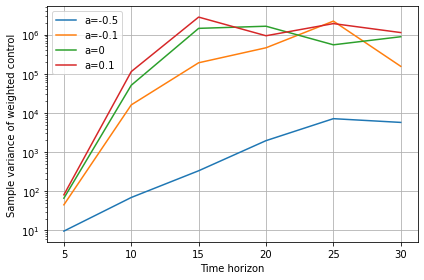

In [98]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for i in range(len(list_a_s)):
    print('a:', list_a_s[i], list_var_2D[i])
    ax.plot(list_N, list_var_2D[i], label='a='+str(list_a_s[i]))

ax.set_yscale('log')
ax.legend()
ax.grid()
ax.set_xlabel('Time horizon')
ax.set_ylabel('Sample variance of weighted control')

plt.tight_layout()
fig.savefig('figures/figure2.pdf', format='pdf')
fig.savefig('figures/figure2.png')
plt.show()

In [83]:
num_chars = zip([1,2,3], ['a','b','c'])
for n, c in num_chars:
    print(n,c)

1 a
2 b
3 c


a: -0.5 [   9.56291771   69.13986206  333.01071167 1960.0213623  7140.45605469
 5729.8671875 ]
a: -0.1 [4.49180832e+01 1.60693076e+04 1.91529359e+05 4.62712312e+05
 2.22217800e+06 1.55308531e+05]
a: 0 [6.64001770e+01 5.10378008e+04 1.45087925e+06 1.64451275e+06
 5.51162875e+05 8.86779188e+05]
a: 0.1 [8.08892670e+01 1.14010031e+05 2.81409475e+06 9.39226438e+05
 1.91926512e+06 1.13239738e+06]


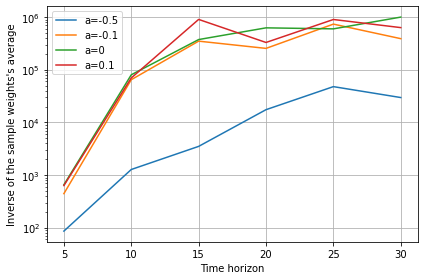

In [102]:


fig, ax = plt.subplots()

for i in range(len(list_a_s)):
    print('a:', list_a_s[i], list_var_2D[i])
    ax.plot(list_N, 1/(list_mean_energy_2D[i]), label='a='+str(list_a_s[i]))

ax.set_yscale('log')
ax.legend()
ax.grid()
ax.set_xlabel('Time horizon')
ax.set_ylabel('Inverse of the sample weights\'s average')

plt.tight_layout()
fig.savefig('figures/figure3.pdf', format='pdf')
fig.savefig('figures/figure3.png')
plt.show()



Simulate and Plot the results.

100%|██████████████████████████████████████████████████████████████████████████████| 7000/7000 [01:23<00:00, 83.42it/s]
No handles with labels found to put in legend.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


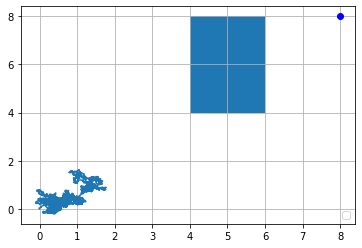

In [136]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


fig, ax = plt.subplots()

list_gammas = [0.0, 0.7]

    
x_sim_result, u_sim_result = run_sim()

if DEVICE != "cpu":
    x = x_sim_result[:,0].cpu().numpy()
    y = x_sim_result[:,1].cpu().numpy()
else:
    x = x_sim_result[:,0].numpy()
    y = x_sim_result[:,1].numpy()

ax.plot(x, y) 
    
### Add goal positions ###
if DEVICE != "cpu":
    np_X_goal = X_goal.cpu().numpy()
else:
    np_X_goal = X_goal.numpy()

### Add goal positions ###
ax.plot(np_X_goal[0,0], np_X_goal[0,1], 'bo')

### Add the rect. obs. ###
LB_X = cost_calculator.Box_to_Avoid['LB_X']
UB_X = cost_calculator.Box_to_Avoid['UB_X']
LB_Y = cost_calculator.Box_to_Avoid['LB_Y']
UB_Y = cost_calculator.Box_to_Avoid['UB_Y']

ax.add_patch(Rectangle((LB_X, LB_Y), UB_X - LB_X, UB_Y - LB_Y))
    
ax.grid()
plt.legend(loc='lower right')
fig.savefig('figures/example1.eps', format='eps')
fig.savefig('figures/example1.png')
plt.show()

In [137]:
import pickle

dict_variance_mon={}

pickle.dump([x,y], open('VAR_UAV_MPPI_'+str(a)+'_'+str(N)+'.p', "wb" ))

# For the unstable (a = 0.5) and the stable (a=-0.5), let us see the variance.